# Using Split Lyapunov Surface
### to calculate orbits near Sun-Earth L1

### Initialization

In [2]:
import orbipy as op
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [18]:
model = op.crtbp3_model()
stmmodel = op.crtbp3_model(stm=True)
plotter = op.plotter.from_model(model, length_units='Mm')
scale = plotter.scaler
pmodel = op.crtbp3_model() # precision model
pmodel.integrator.set_params(max_step=scale(1, 'd-nd'))

In [4]:
# initial position and step size
x0 = model.L1 - 100000/model.R
z0 = 500000/model.R
dx = -1000/model.R

In [5]:
# left and right planes to calculate first 4 orbits
left = op.eventX(model.L1-1.5e6/model.R)
right = op.eventX(model.L1+1.5e6/model.R)

corrp = op.border_correction(model, op.y_direction(), left, right)

### First 4 orbits using border correction with planes

In [6]:
# calculate first 4 orbits
states = []
jacobis = []

for x in [x0+dx, x0+2*dx, x0+3*dx, x0+4*dx]:
    s0 = model.get_zero_state()
    s0[0] = x
    s0[2] = z0
    dv = corrp.calc_dv(0., s0)
    s0 += dv
    states.append(s0)
    jacobis.append(model.jacobi(s0))

### Calculate next set of orbits using split lyapunov surface
#### Every next run adds new orbits states to states list

In [7]:
# calculate next bunch of orbits using cubic extrapolation for jacobi constant initial guess
# eventSPL needs this initial guess
i = 0
while i < 500:
    jint = interp1d([states[j][0] for j in range(-4, 0)],
                    [jacobis[j] for j in range(-4, 0)], 
                    kind='cubic',
                    fill_value='extrapolate')
    x = states[-1][0] + dx
    jc = jint(x)
    evL = op.eventSPL(model, jc, accurate=False)
    evR = op.eventSPL(model, jc, left=False, accurate=False)
    corr = op.border_correction(model, op.y_direction(), evL, evR, maxt=1000., dv0=0.01)
    s0 = model.get_zero_state()
    s0[0] = x
    s0[2] = z0
    dv = corrp.calc_dv(0., s0)
    s0 += dv
    states.append(s0)
    jacobis.append(model.jacobi(s0))
    print('%03d'%i, '%10.2f'%((x - model.L1)*model.R), dv[4], jc)
    i += 1
print('Done')

000 -105000.00 0.0075902936866655306 3.000799702156547
001 -106000.00 0.007645009895272139 3.00079899489724
002 -107000.00 0.007699831734287911 3.0007982806292848
003 -108000.00 0.00775475960644421 3.000797559311204
004 -109000.00 0.007809793912503337 3.000796830901273
005 -110000.00 0.007864935051103927 3.0007960953575803
006 -111000.00 0.007920183418605049 3.000795352637995
007 -112000.00 0.007975539408931311 3.0007946027002035
008 -113000.00 0.00803100341338769 3.000793845501645
009 -114000.00 0.00808657582051374 3.0007930809996206
010 -115000.00 0.008142257015704002 3.000792309151196
011 -116000.00 0.008198047381742055 3.0007915299132657
012 -117000.00 0.008253947296645733 3.000790743242497
013 -118000.00 0.008309957137702282 3.000789949095528
014 -119000.00 0.008366077275949168 3.000789147428452
015 -120000.00 0.008422308079293188 3.0007883381977427
016 -121000.00 0.008478649911497835 3.000787521359183
017 -122000.00 0.00853510313192821 3.0007866968687034
018 -123000.00 0.00859166

In [8]:
len(states)

504

### Make station-keeping and plot orbit

In [9]:
# initialize station-keeping algorithm for last state
corr_unst = op.border_correction(model, op.unstable_direction_stm(stmmodel), evL, evR, maxt=1000.)
sk = op.simple_station_keeping(model, corr, corr_unst, rev=np.pi/2)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


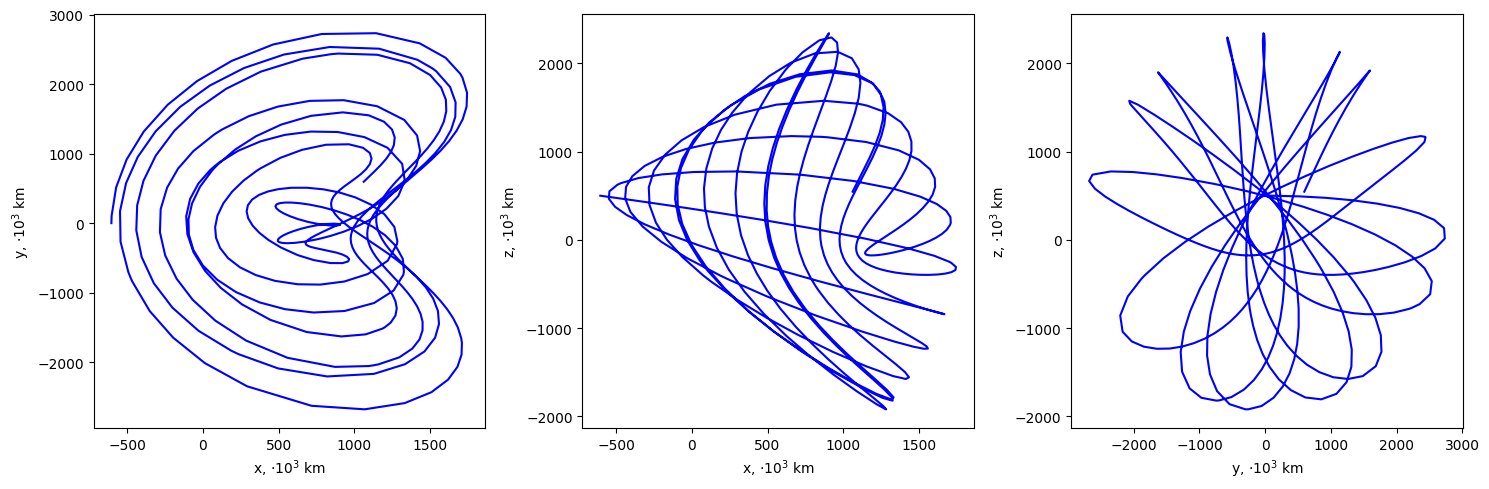

In [10]:
# propagate last state for 20 corrections
df = sk.prop(0.0, states[-1], 20)
plotter.plot_proj(df, centers={'x':model.L1});

In [11]:
# check maximum delta-v (should be less than integration tolerance, i.e. 1e-12)
max_dv = np.max(np.linalg.norm(sk.dvout[:,1:], axis=1)[1:])
print('max_dv:', max_dv, 'nd/nd')
print('max_dv:', scale(max_dv,'nd/nd-cm/s'), 'cm/s')

max_dv: 2.3004150390625003e-13 nd/nd
max_dv: 6.856635345282621e-07 cm/s


### Forbidden zone and split point

In [12]:
def calc_v(xy, J):
    return 2*model.omega(np.array([xy[0], xy[1], 0.0])) - J

In [14]:
# calculate horizontal lyapunov orbit, forbidden zone, split point
xy = []
for th in evL.theta:
    xy.append(evL.get_xy(th))
    
spl_th = evL.split_theta
spl_xy = evL.get_xy(spl_th)
xy = np.array(xy)

vel2 = np.array([calc_v(xyi, jacobis[-1]) for xyi in xy])
mask = (vel2 <= 0)
#np.any(mask)

xy = pd.DataFrame({'x':xy[:,0], 'y':xy[:,1]})
spl_xy = pd.DataFrame({'x':[spl_xy[0]], 'y':[spl_xy[1]]})

/home/tka4nik/Workdir/diploma/project/.venv/lib64/python3.12/site-packages/matplotlib/text.py:897: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/tka4nik/Workdir/diploma/project/.venv/lib64/python3.12/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/tka4nik/Workdir/diploma/project/.venv/lib64/python3.12/site-packages/matplotlib/text.py:756: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/home/tka4nik/Workdir/diploma/project/.venv/lib64/python3.12/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single eleme

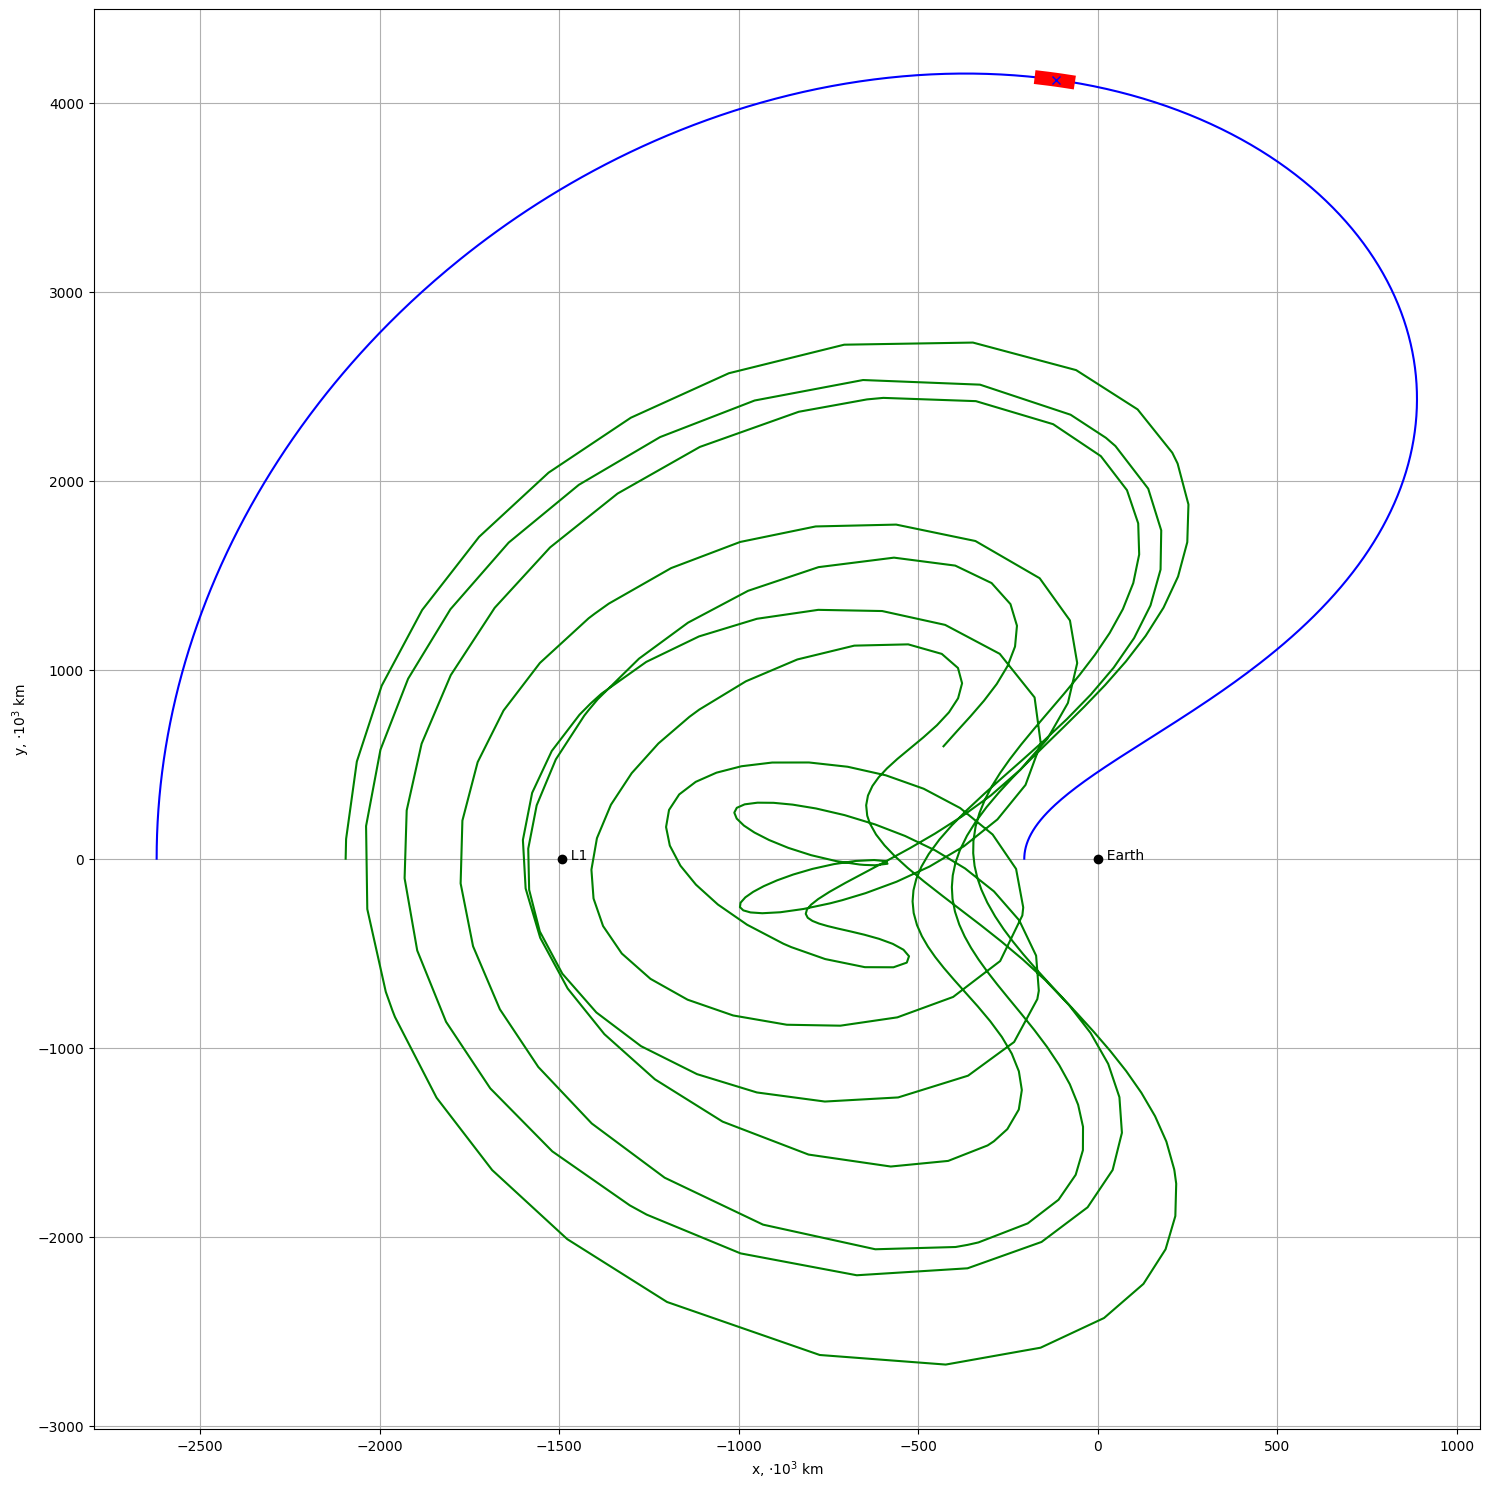

In [15]:
# plot all in x-y projection
ax = plotter.plot_proj(xy, fsize=(15,15), projections=('x-y',), centers={'x':model.mu1});
plotter.plot_proj(xy[mask], ax=ax, projections=('x-y',), centers={'x':model.mu1}, colors='r', linewidth=10);
plotter.plot_proj(spl_xy, ax=ax, projections=('x-y',), centers={'x':model.mu1}, marker='x');
plotter.plot_proj(df, ax=ax, projections=('x-y',), centers={'x':model.mu1}, colors='g');
plotter.plot_proj(plottables=[plotter.L1, plotter.m], projections=('x-y',), ax=ax, 
                  centers={'x':model.mu1}, marker='o', colors='k',
                 grid=True);
#ax.set_xlim(-100, 100)

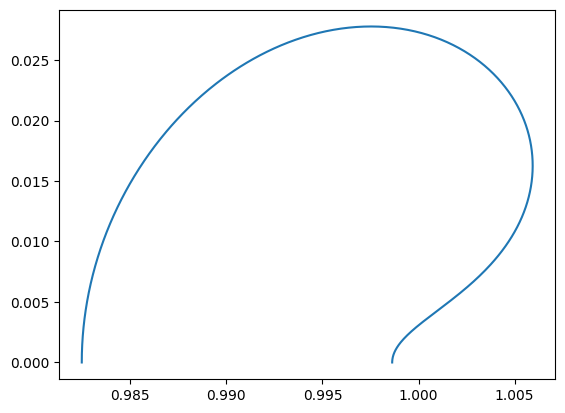

In [16]:
plt.plot(xy.x, xy.y)

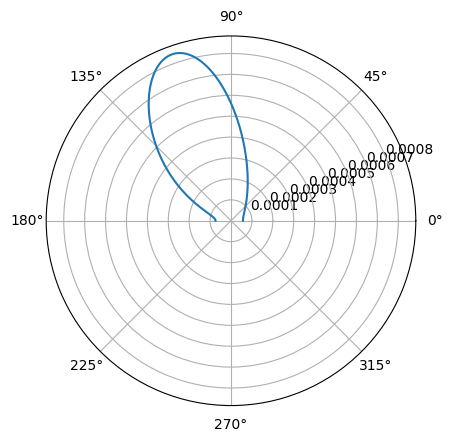

In [17]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(evL.theta, evL.r)
plt.show()